In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot


In [2]:


def t_from_x(x):
    return jnp.log(1/x)

def x_from_t(t):
    return jnp.exp(-t)


def construct_cdf(function, t_func):

    def cdf(x, alpha, params):
        t = t_func(x)
        return jnp.nan_to_num(jnp.exp(-function(t, alpha, params)))
    return cdf



def construct_pdf(function, t_func):

    cdf = construct_cdf(function, t_func)
    derivative = jax.grad(cdf, argnums=0)

    def pdf(x, alpha, params):
        return jnp.nan_to_num(derivative(x, alpha, params) )

    return pdf









In [3]:
print(polynomial(5, 5, jnp.array([[1,1]])))

derivative = jax.grad(polynomial, argnums=0)
print(derivative(0.0, 0.0, jnp.array([[0,], [1,]])))

derivative2 = jax.grad(derivative, argnums=0)
print(derivative2(0.0, 0.0, jnp.array([[1,]])))

derivative3 = jax.grad(derivative2, argnums=0)
print(derivative3(0.0, 0.0, jnp.array([[1.0, 0.0] ])))

# derivative4 = jax.grad(derivative3, argnums=0)
# print(derivative4(0.0, 0.0, integral_coeffs[:2,:2]))




No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


6.0
0.0
0.0
0.0


In [4]:




def integrate_taylor_polynomial(c):
  

    M_plus_1, N_plus_1 = c.shape
    M = M_plus_1 - 1
    N = N_plus_1 - 1
    
    # New array will have shape (M+1, N+2)
    d = np.zeros((M_plus_1, N_plus_1 + 1), dtype=c.dtype)
    
    # d[m,n] = c[m,n-1]/n, except d[m,0] = 0.
    for m in range(M_plus_1):
        for n in range(1, N+2):
            d[m, n] = c[m, n-1] / n

    return d





def matching_coeffs(f, M, N):

    coeffs = taylor_expand_2d(f, 0.0, 0.0, M, N)
    integral_coeffs = integrate_taylor_polynomial(coeffs)

    K = M + N


    polynomial_coeffs = polynomial_sum([polynomial_power(integral_coeffs, k+1) / (k+1.0) for k in range(K+1)])
    return polynomial_coeffs[:M+1, :N+1]





/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:124: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)
/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:124: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


[[0.    0.    0.    0.    0.   ]
 [0.    0.    0.5   0.    0.   ]
 [0.    0.    0.    0.    0.125]]


Text(0, 0.5, '$CDF(x|\\alpha)$')

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


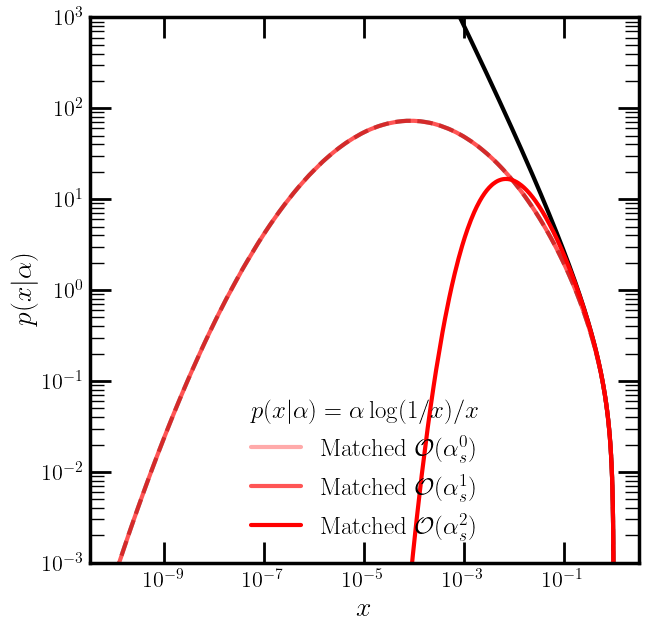

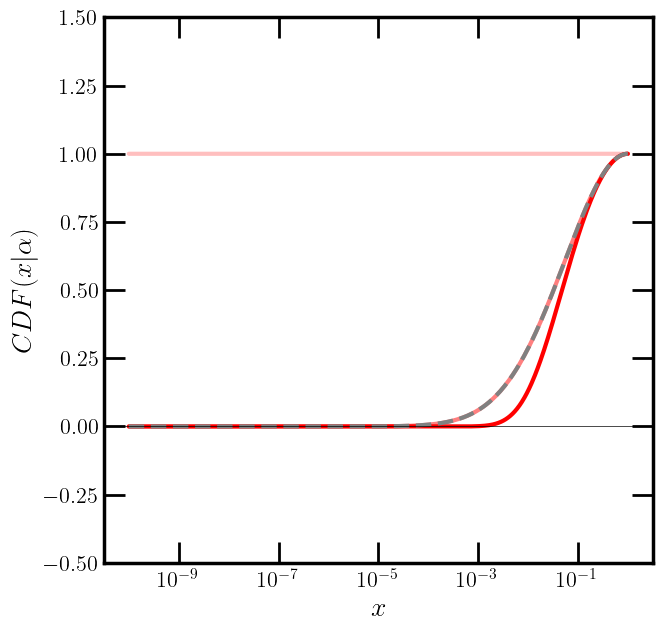

In [5]:
alpha = 0.118



def example_f(t, alpha, params):


    # return jnp.exp(-alpha / 2 * t**2) * (alpha * t)

    alpha_bar  = alpha #* 4/3 / jnp.pi
    return 0.5 * (2*alpha_bar * t ) #  - 4*alpha_bar**2 * t**3 / 2 + 5*(alpha_bar)**3 * t**5 / 6 )


example_coeffs = taylor_expand_2d(example_f, 0.0, 0.0, 1, 2)
# print(example_coeffs)


# example_f = lambda t, alpha, params: polynomial(t, alpha, example_coeffs)


def f_x(x, alpha, params):
    t = t_from_x(x)
    return example_f(t, alpha, params) / x
f_x = jax.vmap(f_x, in_axes=(0, None, None))

x = jnp.logspace(-10, 0, 1000000)
t = t_from_x(x)

pdf = construct_pdf(polynomial, t_from_x)
pdf = jax.vmap(pdf, in_axes=(0, None, None))

fig, ax = newplot("full")


ax.plot(x, f_x(x, alpha, None) , color = 'black', ls = "-")
ax.plot(x, alpha * jnp.log(1/x) / x * jnp.exp( -alpha / 2 * jnp.log(1/x)**2), color = 'grey', ls = "--")


order = 1
matched_coeffs = matching_coeffs(example_f, order, 2 * order)
print(matched_coeffs)
for i in range(order+1):
    o = i 
    ax.plot(x, pdf(x, alpha, matched_coeffs[:o + 1]), label=r"Matched $\mathcal{O}(\alpha_s^{" + str(o)+ r"})$", color = "red", alpha = (i+1)/(order+1))


plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-3, 1e3)

plt.xlabel(r"$x$")
plt.ylabel(r"$p(x|\alpha)$")

plt.legend(title=r"$p(x|\alpha) =\alpha\log(1/x)/x $")


# Plot the CDFs
cdf = construct_cdf(polynomial, t_from_x)
cdf = jax.vmap(cdf, in_axes=(0, None, None))

fig, ax = newplot("full")
# ax.plot(x, polynomial_f(t, alpha, integral_coeffs), label="Original", color = "black")
ax.plot(x, cdf(x, alpha, matched_coeffs), label=r"Matched $\mathcal{O}(\alpha_s^3)$", color = "red")
ax.plot(x, cdf(x, alpha, matched_coeffs[:-1]), label=r"Matched $\mathcal{O}(\alpha_s^2)$", color = "red", alpha = 0.5)
ax.plot(x, cdf(x, alpha, matched_coeffs[:-2]), label=r"Matched $\mathcal{O}(\alpha_s^1)$", color = "red", alpha = 0.25)

# ax.plot(x, 1- alpha * jnp.log(1/x) ** 2, color = 'black', ls = "-")
ax.plot(x, jnp.exp( -alpha / 2 * jnp.log(1/x)**2), color = 'grey', ls = "--")
ax.axhline(0, color = "black", ls = "-", lw = 0.5)


plt.xscale("log")
plt.ylim(-0.5, 1.5)

plt.xlabel(r"$x$")
plt.ylabel(r"$CDF(x|\alpha)$")




In [6]:
def id(x):
    return -x

pdf = construct_pdf(polynomial, id)
pdf = jax.jit(pdf)
print(pdf(0.0, 0.0, matched_coeffs))


qmn = taylor_expand_2d(pdf, 0.0, 0.0, 3, 6, params=matched_coeffs)

-0.0


/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:124: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


KeyboardInterrupt: 

p_mn:
 [[0. 0. 0.]
 [0. 1. 0.]]
q_mn:
 [[ 0.  0.  0.  0.  0.]
 [-0.  1. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]]


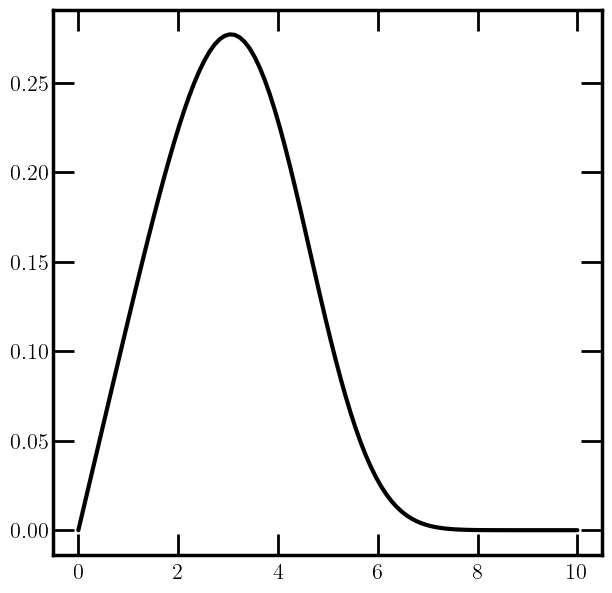

In [50]:
ts = jnp.linspace(0, 10, 100)
alpha = 0.118

vmapped_pdf = jax.vmap(pdf, in_axes=(0, None, None))

fig, ax = newplot("full")
ax.plot(ts, -vmapped_pdf(ts, alpha, matched_coeffs), label="PDF", color = "black")


print("p_mn:\n", example_coeffs)
print("q_mn:\n", -qmn)

In [28]:
import jax.numpy.linalg as jla
from utils.function_utils import build_powers

def polynomial_roots(c):
    
    
    roots = jnp.roots(c[::-1])
    return roots



def collapse_2d_coeffs(alpha, params):

    M, N = params.shape

    alpha_powers = build_powers(alpha, M)  # shape (M,)

    return alpha_powers @ params


print(example_coeffs)


c = example_coeffs
roots = polynomial_roots(collapse_2d_coeffs(1, c))
print(roots)

[[ 0.   0.  -0.   0.   0. ]
 [ 0.   1.   0.   0.   0. ]
 [-0.   0.   0.  -0.5  0. ]]
[ 0.       +0.j  1.4142135+0.j -1.4142135+0.j]
